# Regression MPE

Here we try to create regressions to predict Variaz on the basis of other features

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import folium
import geopandas as gpd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import math
import folium
import datetime
from os import listdir
from os.path import isfile, join

from matplotlib import gridspec
from matplotlib.backends.backend_pdf import PdfPages

import statsmodels.api as sm
from stargazer.stargazer import Stargazer

In [2]:
variaz = pd.read_csv('quake_data/variaz_phone_all.csv', sep=',')
variaz

,Comune,Cratere Centro Italia 2016,media_prima,media_dopo,varPhones,Variaz,Variaz_init,Variaz_end
0,Abbateggio,0.0,490.128191,528.004679,0.077279,-14.463816,0.705066,-19.227151
1,Acciano,0.0,768.136868,819.775802,0.067226,-14.874264,-4.698444,-18.069677
2,Accumoli,1.0,1851.535702,756.245581,-0.591558,-50.161357,-10.301179,-62.678257
3,Acquacanina,1.0,661.076764,515.862884,-0.219663,-34.800125,-9.641580,-42.700415
4,Acqualagna,0.0,6232.440927,6788.446451,0.089212,-9.518700,-9.400079,-9.555950
...,...,...,...,...,...,...,...,...
658,Villa Santa Lucia degli Abruzzi,0.0,619.704165,615.334550,-0.007051,-10.220925,-5.554247,-11.686356
659,Villamagna,0.0,2299.570141,2671.182335,0.161601,-4.337274,1.206108,-6.078008
660,Visso,1.0,3745.319302,2389.214715,-0.362080,-39.942473,-18.534044,-46.665151
661,Viterbo,0.0,59906.488893,70060.167213,0.169492,7.167185,2.410811,8.660783


In [3]:
distance = pd.read_csv('quake_data/distance_from_epicenter.csv', sep=',')
variaz = variaz.merge(distance)
variaz.head()

,Comune,Cratere Centro Italia 2016,media_prima,media_dopo,varPhones,Variaz,Variaz_init,Variaz_end,Distance_from_epicenter
0,Abbateggio,0.0,490.128191,528.004679,0.077279,-14.463816,0.705066,-19.227151,84.008154
1,Acciano,0.0,768.136868,819.775802,0.067226,-14.874264,-4.698444,-18.069677,67.559108
2,Accumoli,1.0,1851.535702,756.245581,-0.591558,-50.161357,-10.301179,-62.678257,0.000000
3,Acquacanina,1.0,661.076764,515.862884,-0.219663,-34.800125,-9.641580,-42.700415,14.633192
4,Acqualagna,0.0,6232.440927,6788.446451,0.089212,-9.518700,-9.400079,-9.555950,94.928297


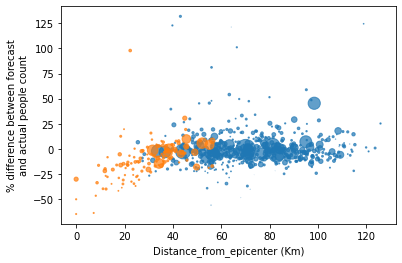

In [4]:
crat0 = variaz[variaz['Cratere Centro Italia 2016']==0]
crat1 = variaz[variaz['Cratere Centro Italia 2016']==1]
plt.scatter(crat0['Distance_from_epicenter'],crat0['Variaz'],s=crat0['media_dopo'] / 500,alpha=0.7)
plt.scatter(crat1['Distance_from_epicenter'],crat1['Variaz'],s=crat1['media_dopo'] / 500,alpha=0.7)
plt.xlabel('Distance_from_epicenter (Km)')
plt.ylabel('% difference between forecast\nand actual people count',multialignment='center')
plt.savefig('images/distance_desnt_explain.pdf',bbox_inches='tight')  
plt.show()

In [5]:
industries = pd.read_csv('quake_data/imprese_ateco_wide_norm_by_pop.csv', sep=',')
ateco_names = list(industries.columns)[1:]
industries['INDUSTRIES']=industries.loc[:,ateco_names].sum(axis='columns')
industries = industries[['Comune','INDUSTRIES']]
industries

,Comune,INDUSTRIES
0,Acciano,0.495522
1,Accumoli,2.815267
2,Acquasanta Terme,4.155366
3,Acquasparta,17.873539
4,Acquaviva Picena,16.174458
...,...,...
355,Vallo di Nera,4.043478
356,Valtopina,4.119913
357,Venarotta,1.990380
358,Villa Sant'Angelo,0.247727


Distance from epicenter alone cannot explain Variaz


In [6]:
imprese_ateco_wide = pd.read_csv('quake_data/imprese_ateco_wide.csv', sep=',')
#imprese_ateco_wide = pd.read_csv('quake_data/imprese_ateco_wide_norm_by_pop.csv', sep=',')
imprese_ateco_wide.head(2)

,Comune,AGRICOLTURE,REAL ESTATE,HOSPITALITY,MANUFACTURING,TECH SERVICES,WHOLE/RETAIL SALES,CONSTRUCTIONS,BUSINESS SUPPORT SERVICES,COMMUNICATION AND INFORMATION SERV.,LOGISTICS
0,Abbateggio,0.0,0.0,0.24878,0.0,0.0,0.000000,0.75122,0.000000,0.0,0.0
1,Acciano,0.0,0.0,0.00000,0.0,0.0,0.771084,0.00000,0.228916,0.0,0.0


In [7]:
ateco_names = list(imprese_ateco_wide.columns)[1:]
ateco_names

['AGRICOLTURE',
 'REAL ESTATE',
 'HOSPITALITY',
 'MANUFACTURING',
 'TECH SERVICES',
 'WHOLE/RETAIL SALES',
 'CONSTRUCTIONS',
 'BUSINESS SUPPORT SERVICES',
 'COMMUNICATION AND INFORMATION SERV.',
 'LOGISTICS']

In [8]:
imprese_ateco_wide = imprese_ateco_wide.merge(industries)
imprese_ateco_wide

,Comune,AGRICOLTURE,REAL ESTATE,HOSPITALITY,MANUFACTURING,TECH SERVICES,WHOLE/RETAIL SALES,CONSTRUCTIONS,BUSINESS SUPPORT SERVICES,COMMUNICATION AND INFORMATION SERV.,LOGISTICS,INDUSTRIES
0,Acciano,0.000000,0.000000,0.000000,0.000000,0.000000,0.771084,0.000000,0.228916,0.0,0.000000,0.495522
1,Accumoli,0.301518,0.065076,0.000000,0.000000,0.000000,0.459328,0.000000,0.000000,0.0,0.174078,2.815267
2,Acquasanta Terme,0.000000,0.001230,0.036241,0.509593,0.001558,0.266809,0.142096,0.003772,0.0,0.038701,4.155366
3,Acquasparta,0.000000,0.005197,0.020643,0.438052,0.000856,0.171972,0.056555,0.000119,0.0,0.306606,17.873539
4,Acquaviva Picena,0.000000,0.003504,0.010560,0.756879,0.011723,0.179051,0.036104,0.000113,0.0,0.002067,16.174458
...,...,...,...,...,...,...,...,...,...,...,...,...
355,Vallo di Nera,0.000000,0.000000,0.769489,0.000000,0.000000,0.000000,0.230511,0.000000,0.0,0.000000,4.043478
356,Valtopina,0.033339,0.000000,0.083613,0.576469,0.000000,0.000000,0.306580,0.000000,0.0,0.000000,4.119913
357,Venarotta,0.011841,0.000000,0.010150,0.413001,0.000000,0.000000,0.565007,0.000000,0.0,0.000000,1.990380
358,Villa Sant'Angelo,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.247727


In [9]:
urb = pd.read_csv('quake_data/Classificazioni statistiche-e-dimensione-dei-comuni_2016.csv',sep=';')
urb = urb[['Denominazione (italiana e straniera)','Grado di urbanizzazione']]
urb.columns = ['Comune','URBANIZATION']
urb

,Comune,URBANIZATION
0,Agliè,2
1,Airasca,3
2,Ala di Stura,3
3,Albiano d'Ivrea,3
4,Alice Superiore,3
...,...,...
7993,Sant'Anna Arresi,3
7994,Sant'Antioco,2
7995,Tratalias,3
7996,Villamassargia,3


In [10]:
xy = pd.merge(variaz, imprese_ateco_wide, how='inner', on='Comune').fillna(0)
xy = pd.merge(xy,urb, how='inner', on='Comune').fillna(0)
#xy['Distance_from_epicenter']=(xy['Distance_from_epicenter']-xy['Distance_from_epicenter'].mean())/xy['Distance_from_epicenter'].std()

xy.columns = ['Comune', 'CRATER', 'PHONE_BEFORE', 'PHONE_AFTER',
              'PCGH', 'MPE', 'MPE_INIT','MPE_END','DISTANCE FROM EPICENTER']+ateco_names+['INDUSTRIES']+['URBANIZATION']

xy

,Comune,CRATER,PHONE_BEFORE,PHONE_AFTER,PCGH,MPE,MPE_INIT,MPE_END,DISTANCE FROM EPICENTER,AGRICOLTURE,...,HOSPITALITY,MANUFACTURING,TECH SERVICES,WHOLE/RETAIL SALES,CONSTRUCTIONS,BUSINESS SUPPORT SERVICES,COMMUNICATION AND INFORMATION SERV.,LOGISTICS,INDUSTRIES,URBANIZATION
0,Acciano,0.0,768.136868,819.775802,0.067226,-14.874264,-4.698444,-18.069677,67.559108,0.000000,...,0.000000,0.000000,0.000000,0.771084,0.000000,0.228916,0.0,0.000000,0.495522,3
1,Accumoli,1.0,1851.535702,756.245581,-0.591558,-50.161357,-10.301179,-62.678257,0.000000,0.301518,...,0.000000,0.000000,0.000000,0.459328,0.000000,0.000000,0.0,0.174078,2.815267,3
2,Acquasanta Terme,1.0,4675.825569,4551.677407,-0.026551,-20.581043,-9.636775,-24.017764,15.157389,0.000000,...,0.036241,0.509593,0.001558,0.266809,0.142096,0.003772,0.0,0.038701,4.155366,3
3,Acquasparta,0.0,5907.149691,6861.913495,0.161629,-2.084250,0.337956,-2.844872,47.488818,0.000000,...,0.020643,0.438052,0.000856,0.171972,0.056555,0.000119,0.0,0.306606,17.873539,3
4,Acquaviva Picena,0.0,4730.747185,5541.411212,0.171361,6.299099,1.967787,7.659218,51.096912,0.000000,...,0.010560,0.756879,0.011723,0.179051,0.036104,0.000113,0.0,0.002067,16.174458,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,Vallo di Nera,1.0,1429.670006,1421.002792,-0.006062,-15.279045,-11.654111,-16.417347,20.893057,0.000000,...,0.769489,0.000000,0.000000,0.000000,0.230511,0.000000,0.0,0.000000,4.043478,3
356,Valtopina,0.0,2466.865696,2637.925328,0.069343,-9.963762,-3.970573,-11.845744,40.114811,0.033339,...,0.083613,0.576469,0.000000,0.000000,0.306580,0.000000,0.0,0.000000,4.119913,3
357,Venarotta,1.0,2951.416882,2989.851639,0.013022,-12.366800,-3.825055,-15.049081,26.204571,0.011841,...,0.010150,0.413001,0.000000,0.000000,0.565007,0.000000,0.0,0.000000,1.990380,3
358,Villa Sant'Angelo,0.0,231.959555,267.578877,0.153558,-15.157541,-4.822680,-18.402895,53.444851,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.247727,3


In [11]:
def add_regioni(df):
    cod_reg_nome = pd.DataFrame({'COD_REG':[10,11,12,13],'Regione':['UMBRIA','MARCHE','LAZIO','ABRUZZO']})
    comune_regione = pd.read_csv('quake_data/comune_regione.csv').merge(cod_reg_nome)[['Comune','Regione']]
    df = df.merge(comune_regione)
    regioni = pd.get_dummies(df['Regione']) #one hot encoding
    df = pd.concat([df,regioni],axis='columns').drop(['Regione'],axis='columns')
    return df

xy = add_regioni(xy)

In [12]:
alt = pd.read_csv('quake_data/Elab_Altimetrie_DEM.csv',sep=';')
alt = alt.loc[alt['COD_REG'].isin([10,11,12,13]),['NOME','ALT_MIN','MEDIA','MEDIANA']]
alt.columns = ['Comune','ALT_MIN','ALT_MEAN','ALT_MED']
xy = xy.merge(alt)

In [13]:
#near = pd.read_csv('quake_data/distance_from_big.csv')
#near.columns = ['Comune','DIST_FROM_BIG']
#xy = xy.merge(near)
#xy['DIST_FROM_BIG'] = xy['DIST_FROM_BIG'] / max(xy['DIST_FROM_BIG'])
#xy_crat = xy_crat.merge(near)
#xy_crat['DIST_FROM_BIG'] = xy_crat['DIST_FROM_BIG'] / max(xy_crat['DIST_FROM_BIG'])
#print(xy.shape)
#print(xy_crat.shape)
xy

,Comune,CRATER,PHONE_BEFORE,PHONE_AFTER,PCGH,MPE,MPE_INIT,MPE_END,DISTANCE FROM EPICENTER,AGRICOLTURE,...,LOGISTICS,INDUSTRIES,URBANIZATION,ABRUZZO,LAZIO,MARCHE,UMBRIA,ALT_MIN,ALT_MEAN,ALT_MED
0,Acciano,0.0,768.136868,819.775802,0.067226,-14.874264,-4.698444,-18.069677,67.559108,0.000000,...,0.000000,0.495522,3,1,0,0,0,454,858.6765,872
1,Accumoli,1.0,1851.535702,756.245581,-0.591558,-50.161357,-10.301179,-62.678257,0.000000,0.301518,...,0.174078,2.815267,3,0,1,0,0,670,1181.8030,1125
2,Acquasanta Terme,1.0,4675.825569,4551.677407,-0.026551,-20.581043,-9.636775,-24.017764,15.157389,0.000000,...,0.038701,4.155366,3,0,0,1,0,242,860.2225,825
3,Acquasparta,0.0,5907.149691,6861.913495,0.161629,-2.084250,0.337956,-2.844872,47.488818,0.000000,...,0.306606,17.873539,3,0,0,0,1,196,471.9593,392
4,Acquaviva Picena,0.0,4730.747185,5541.411212,0.171361,6.299099,1.967787,7.659218,51.096912,0.000000,...,0.002067,16.174458,3,0,0,1,0,44,182.7404,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,Vallo di Nera,1.0,1429.670006,1421.002792,-0.006062,-15.279045,-11.654111,-16.417347,20.893057,0.000000,...,0.000000,4.043478,3,0,0,0,1,299,781.4977,785
354,Valtopina,0.0,2466.865696,2637.925328,0.069343,-9.963762,-3.970573,-11.845744,40.114811,0.033339,...,0.000000,4.119913,3,0,0,0,1,324,593.7631,567
355,Venarotta,1.0,2951.416882,2989.851639,0.013022,-12.366800,-3.825055,-15.049081,26.204571,0.011841,...,0.000000,1.990380,3,0,0,1,0,176,432.6170,419
356,Villa Sant'Angelo,0.0,231.959555,267.578877,0.153558,-15.157541,-4.822680,-18.402895,53.444851,0.000000,...,0.000000,0.247727,3,1,0,0,0,556,677.1108,591


In [14]:
xy.to_csv('quake_data/X_regression.csv',index=False)

C:\Users\Marco\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


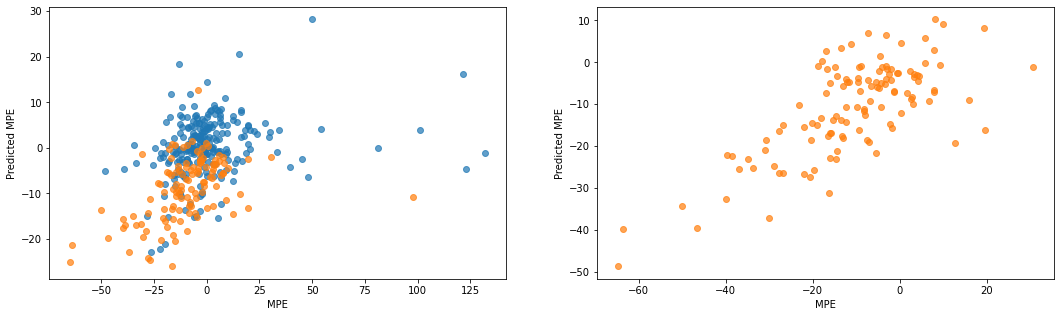

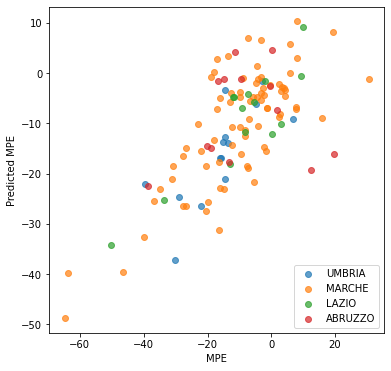

In [19]:

xy_crat = xy.loc[xy['CRATER']==1,:]

feat =  ['DISTANCE FROM EPICENTER','ALT_MED'] + ateco_names + ['INDUSTRIES','URBANIZATION']
# ['UMBRIA','MARCHE','LAZIO','ABRUZZO']
x = xy[feat]
y = xy['MPE'] 

xy_crat = xy_crat.loc[xy_crat['Comune']!='Sellano',:]
x_crat = xy_crat[feat]
y_crat = xy_crat['MPE'] 

#x_crat = x_crat - x_crat.mean() / x_crat.std()
x_crat = x_crat.dropna(axis='columns')

x = sm.add_constant(x)
x_crat = sm.add_constant(x_crat)

model = sm.OLS(y, x).fit()
model_crat = sm.OLS(y_crat, x_crat).fit()

yp = model.predict(x)
yp_crat = model_crat.predict(x_crat)

plt.figure(figsize = (18, 5))
plt.subplot(1,2,1)
plt.scatter(y[xy.loc[xy['CRATER']==0,:].index],yp[xy.loc[xy['CRATER']==0,:].index],alpha=0.7)
plt.scatter(y[xy.loc[xy['CRATER']==1,:].index],yp[xy.loc[xy['CRATER']==1,:].index],alpha=0.7)
plt.xlabel(y.name)
plt.ylabel('Predicted '+y.name)
plt.subplot(1,2,2)
plt.scatter(y_crat[xy_crat.loc[xy_crat['CRATER']==0,:].index],yp_crat[xy_crat.loc[xy_crat['CRATER']==0,:].index],alpha=0.7)
plt.scatter(y_crat[xy_crat.loc[xy_crat['CRATER']==1,:].index],yp_crat[xy_crat.loc[xy_crat['CRATER']==1,:].index],alpha=0.7)
plt.xlabel(y.name)
plt.ylabel('Predicted '+y.name)
plt.show()


plt.figure(figsize = (6,6))
for r in ['UMBRIA','MARCHE','LAZIO','ABRUZZO']:
    plt.scatter(y_crat[xy_crat.loc[xy_crat[r]==1,:].index],yp_crat[xy_crat.loc[xy_crat[r]==1,:].index],alpha=0.7, label=r)
plt.xlabel('MPE')
plt.ylabel('Predicted MPE')
plt.legend(loc='lower right')
plt.savefig('images/model1_region.pdf',bbox_inches='tight')  
plt.show()

In [20]:
#TEST
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
model = LinearRegression(fit_intercept=False, normalize=False)
model.fit(x_crat,y_crat)
yp = model.predict(x_crat)
print('R2 = ',r2_score(y_crat,yp))

R2 =  0.5224699501637993


## Add Analysis for MPE INIT, MPE END, MPE

In [25]:

feat =  ['DISTANCE FROM EPICENTER','ALT_MED'] + ateco_names #+ ['INDUSTRIES','URBANIZATION']
#['UMBRIA','MARCHE','LAZIO','ABRUZZO'] 

targets = ['MPE_INIT','MPE_END','MPE']
models = []
xy_crat = xy_crat.loc[xy_crat['Comune']!='Sellano',:]
for t in targets:
    x_crat = xy_crat[feat]
    y_crat = xy_crat[t] 
    #x_crat = x_crat - x_crat.mean() / x_crat.std()
    x_crat = x_crat.dropna(axis='columns')
    x = sm.add_constant(x)
    x_crat = sm.add_constant(x_crat)
    models.append(sm.OLS(y_crat, x_crat).fit())


stargazer = Stargazer(models)
stargazer.custom_columns(targets,[1]*len(targets))
stargazer.covariate_order(feat)
stargazer.show_model_numbers(False)
with open('models/model_pre_all.tex','w') as f:
        f.write(stargazer.render_latex())
stargazer.render_latex()
stargazer


C:\Users\Marco\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
